In [ ]:
def preprocess_images(images):
    """
    Normalize the images to [-1, 1] range
    """
    num_images, width, height = images.shape
    images = images.reshape(num_images, width, height, 1).astype('float32')
    images = (images - 127.5) / 127.5
    return images

def load_array_with_autotune(data_arrays, batch_size, buffer_size=1000, is_train=True):
    """
    Constructs a TensorFlow data iterator with auto-tuned prefetching.

    Similar to `load_array`, this function creates a data iterator from provided arrays. It also
    incorporates auto-tuning for prefetching data to the device for improved training performance.
    Additionally, it allows specifying a custom buffer size for shuffling (default 1000) and
    controls shuffling based on the `is_train` flag.

    Args:
      data_arrays: A list of NumPy arrays representing your data.
      batch_size: The size of each batch the iterator should produce.
      buffer_size: The buffer size for shuffling (if `is_train` is True).
      is_train: Whether the dataset is used for training (shuffled) or evaluation (no shuffling).

    Returns:
      A TensorFlow `Dataset` iterator with auto-tuned prefetching for efficient data access.
    """

    dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
    if is_train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import os
import PIL
import imageio
import time

from IPython import display
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

print('Train', train_x.shape, train_y.shape)
print('Test', test_x.shape, test_y.shape)

11490434/11490434 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


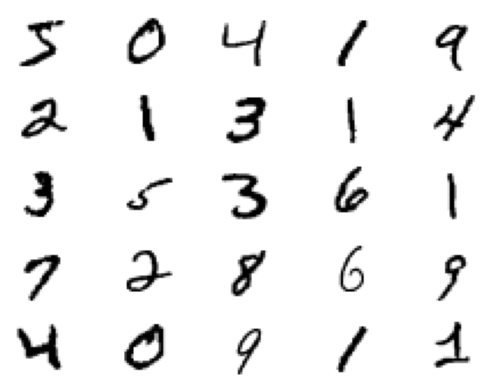

In [ ]:
for i in range(25):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(train_x[i], cmap='gray_r')
plt.show()

In [ ]:
train_x.shape

(60000, 28, 28)

In [ ]:
train_images = preprocess_images(train_x)
train_labels = train_y

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
# buffer_size = 60000
# batch_size = 256


# def load_array(data_arrays, batch_size, is_train=True):
#     """Construct a TensorFlow data iterator."""
#     dataset = tf.data.Dataset.from_tensor_slices(data_arrays)
#     if is_train:
#         dataset = dataset.shuffle(buffer_size=1000)
#     dataset = dataset.batch(batch_size)
#     return dataset

# data_iter = load_array((train_images,), 128)

In [ ]:
buffer_size = 60000
batch_size = 256

data_iter = load_array_with_autotune((train_images,), batch_size, buffer_size)

In [ ]:
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=5, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

n_g = 256
net_G = tf.keras.Sequential([
    # Input: (None, latent_dim)
    tf.keras.layers.Dense(7 * 7 * n_g, use_bias=False, input_shape=(100,)),  # Output: (7, 7, 64)
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Reshape((7, 7, n_g)),  # Adjust input shape to (7, 7)
    G_block(out_channels=n_g / 2, kernel_size=5, strides=1),
    G_block(out_channels=n_g / 4, kernel_size=5, strides=2),
    tf.keras.layers.Conv2DTranspose(
        1, kernel_size=5, strides=2, padding="same", use_bias=False, activation="tanh"
    ),
])

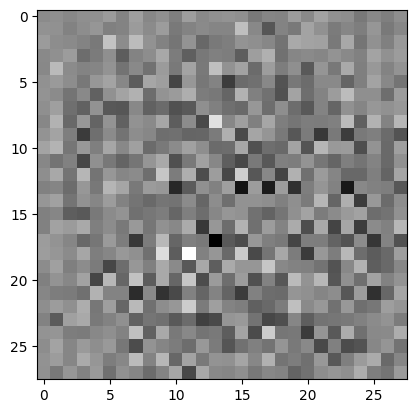

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = net_G(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
net_G.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 g_block (G_block)           (None, 7, 7, 128)         819712    
                                                                 
 g_block_1 (G_block)         (None, 14, 14, 64)        205056    
                                                        

In [ ]:
generated_image.shape

TensorShape([1, 28, 28, 1])

In [ ]:
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, dropout=0.3, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        # self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)
        self.dropout = tf.keras.layers.Dropout(dropout)


    def call(self, X):
        return self.dropout(self.activation(self.conv2d(X)))

n_d = 64
net_D = tf.keras.Sequential([
    # Input: (28by28)
    D_block(out_channels=n_d, kernel_size=5),
    D_block(out_channels=n_d * 2, kernel_size=5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
decision = net_D(generated_image)
print(decision) # without training...

tf.Tensor([[0.49945128]], shape=(1, 1), dtype=float32)


In [ ]:
net_D.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_block (D_block)           (1, 14, 14, 64)           1600      
                                                                 
 d_block_1 (D_block)         (1, 7, 7, 128)            204800    
                                                                 
 flatten (Flatten)           (1, 6272)                 0         
                                                                 
 dense_1 (Dense)             (1, 1)                    6273      
                                                                 
Total params: 212673 (830.75 KB)
Trainable params: 212673 (830.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def train(net_D, net_G, data_iter, hyperparams, seed, num_epochs=20):
    """
    Trains a GAN with hyperparameter tuning.

    Args:
      net_D: Discriminator model.
      net_G: Generator model.
      data_iter: Data iterator.
      hyperparams: Dictionary containing values of hyperparameters.
        - lr_D: learning rate for discriminator.
        - lr_G: learning rate for generator.
        - num_discriminator_updates: number of discriminator updates per batch.
        - latent_dim: dimension of latent space.
      num_epochs: Number of epochs. Default is set at 20.
    """
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_D = tf.keras.optimizers.Adam(learning_rate=hyperparams["lr_D"])
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=hyperparams["lr_G"])

    # Early stopping setup (useless at this point but i use it to see
    # in which epoch lose of net_D is the lowest)
    best_loss_D = float('inf')
    best_epoch = 0

    for epoch in range(num_epochs):
        loss_D_total, loss_G_total, num_examples = 0., 0., 0
        epoch_start_time = time.time() # time for each epoch

        for (X,) in data_iter:
            batch_size = X.shape[0]

            # Train discriminator (multiple times if the user wants)
            for _ in range(hyperparams["num_discriminator_updates"]):
                Z = tf.random.normal(mean=0, stddev=1, shape=(batch_size, hyperparams["latent_dim"]))
                fake_X = net_G(Z, training=True)
                with tf.GradientTape() as tape:
                    real_Y = net_D(X, training=True)
                    fake_Y = net_D(fake_X, training=True)
                    real_loss = loss(tf.ones((batch_size,)), tf.squeeze(real_Y))
                    fake_loss = loss(tf.zeros((batch_size,)), tf.squeeze(fake_Y))
                    loss_D = (real_loss + fake_loss) * batch_size / 2

                grads_D = tape.gradient(loss_D, net_D.trainable_variables)
                optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))

                loss_D_total += loss_D.numpy()
                num_examples += batch_size

            # Train generator
            Z = tf.random.normal(mean=0, stddev=1, shape=(batch_size, hyperparams["latent_dim"]))
            with tf.GradientTape() as tape:
                fake_X = net_G(Z, training=True)
                fake_Y = net_D(fake_X)
                loss_G = loss(tf.ones((batch_size,)), tf.squeeze(fake_Y)) * batch_size

            grads_G = tape.gradient(loss_G, net_G.trainable_variables)
            optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))

            loss_G_total += loss_G.numpy()

        # Calculate average losses and print
        loss_D_avg = loss_D_total / num_examples
        loss_G_avg = loss_G_total / num_examples

        # Early stopping based on discriminator loss
        if loss_D_avg < best_loss_D:
            best_loss_D = loss_D_avg
            best_epoch = epoch

        print(f'Epoch {epoch+1}: loss_D {loss_D_avg:.3f}, loss_G {loss_G_avg:.3f}, {num_examples} examples')
        epoch_end_time = time.time() # time for each epoch
        epoch_time = epoch_end_time - epoch_start_time
        print(f"Epoch {epoch + 1} time: {epoch_time:.2f} seconds")


        if (epoch + 1) % 25 == 0:

            model_name = f"generator_MNIST_epoch_{epoch + 1}.h5"
            net_G.save(f"/content/gdrive/My Drive/{model_name}")
            print(f"Model saved to: {model_name}")

        generated_images = net_G(seed, training=False)
        for i in range(generated_images.shape[0]):
            plt.subplot(5, 5, 1 + i)
            plt.axis('off')
            plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray')
            plt.suptitle(f"Generated Images - Epoch: {epoch + 1}")
            # to save the figure every 20 epoch
            if (epoch + 1) % 20 == 0:
                plt.savefig(f"/content/gdrive/MyDrive/generated_images_MNIST_epoch_{epoch + 1}.png")
        plt.show()

    # Print best epoch based on early stopping
    print(f"Best epoch based on discriminator loss: {best_epoch + 1}")

In [ ]:
num_epochs = 200
hyperparams = {
    'lr_D' : 0.0001,
    'lr_G' : 0.0001,
    'num_discriminator_updates' : 2,
    'latent_dim' : 100
}

# for visual testing while in training
# we make this outside the training loop so we can see the output of the same noise
# over and over...
seed = tf.random.normal(mean=0, stddev=1, shape=(25, hyperparams["latent_dim"]))

start_time = time.time() # for timing
train(net_D, net_G, data_iter, hyperparams, seed, num_epochs)

end_time = time.time()
total_training_time = end_time - start_time # calculating how much time was passed since starting the training loop
print(f"Total training time: {total_training_time:.2f} seconds")

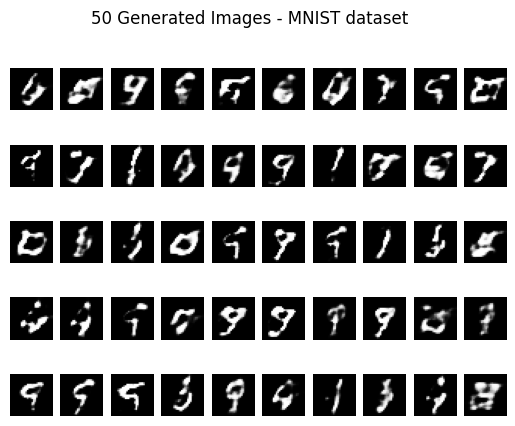

In [ ]:
Z = tf.random.normal(mean=0, stddev=1, shape=(50, hyperparams["latent_dim"]))
generated_images = net_G(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray')
    plt.suptitle(f"50 Generated Images - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_of_MNIST.png")
plt.show()

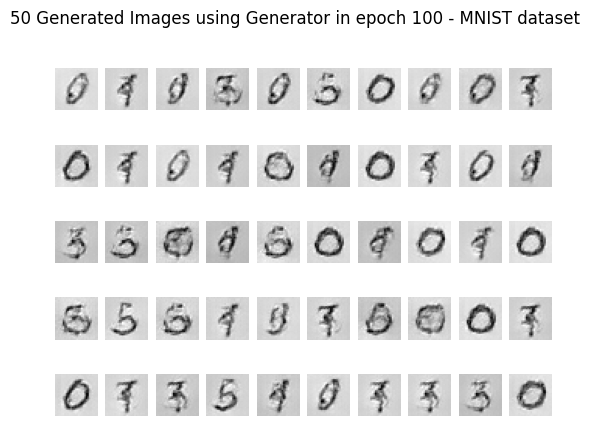

In [ ]:
with tf.keras.utils.custom_object_scope({'G_block': G_block}):
    Generator_at_100_epoch = tf.keras.models.load_model('/content/gdrive/My Drive/generator_MNIST_epoch_100.h5')

Z = tf.random.normal(mean=0, stddev=1, shape=(50, 100))
generated_images = Generator_at_100_epoch(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray_r')
    plt.suptitle(f"50 Generated Images using Generator in epoch 100 - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_withGENat100_MNIST.png")
plt.show()

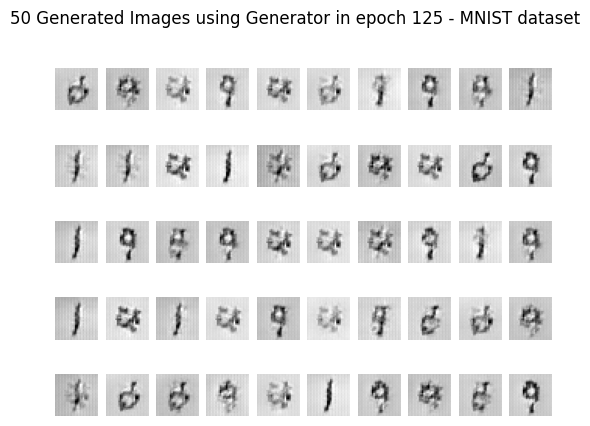

In [ ]:
with tf.keras.utils.custom_object_scope({'G_block': G_block}):
    Generator_at_125_epoch = tf.keras.models.load_model('/content/gdrive/My Drive/generator_MNIST_epoch_125.h5')

Z = tf.random.normal(mean=0, stddev=1, shape=(50, 100))
generated_images = Generator_at_125_epoch(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray_r')
    plt.suptitle(f"50 Generated Images using Generator in epoch 125 - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_withGENat125_MNIST.png")
plt.show()

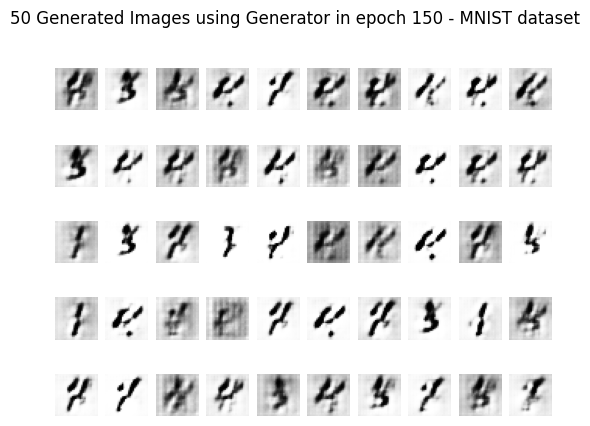

In [ ]:
with tf.keras.utils.custom_object_scope({'G_block': G_block}):
    Generator_at_150_epoch = tf.keras.models.load_model('/content/gdrive/My Drive/generator_MNIST_epoch_150.h5')

Z = tf.random.normal(mean=0, stddev=1, shape=(50, 100))
generated_images = Generator_at_150_epoch(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray_r')
    plt.suptitle(f"50 Generated Images using Generator in epoch 150 - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_withGENat150_MNIST.png")
plt.show()

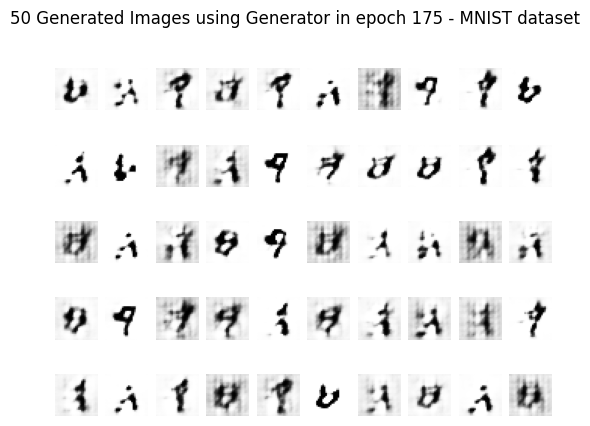

In [ ]:
with tf.keras.utils.custom_object_scope({'G_block': G_block}):
    Generator_at_175_epoch = tf.keras.models.load_model('/content/gdrive/My Drive/generator_MNIST_epoch_175.h5')

Z = tf.random.normal(mean=0, stddev=1, shape=(50, 100))
generated_images = Generator_at_175_epoch(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray_r')
    plt.suptitle(f"50 Generated Images using Generator in epoch 175 - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_withGENat175_MNIST.png")
plt.show()

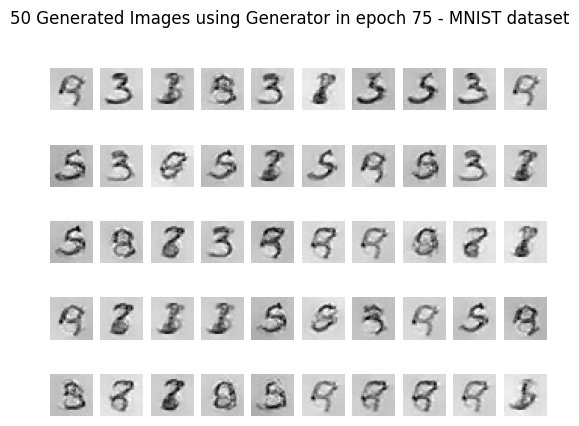

In [ ]:
with tf.keras.utils.custom_object_scope({'G_block': G_block}):
    Generator_at_75_epoch = tf.keras.models.load_model('/content/gdrive/My Drive/generator_MNIST_epoch_75.h5')

Z = tf.random.normal(mean=0, stddev=1, shape=(50, 100))
generated_images = Generator_at_75_epoch(Z, training=False)
for i in range(generated_images.shape[0]):
    plt.subplot(5, 10, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5 , cmap='gray_r')
    plt.suptitle(f"50 Generated Images using Generator in epoch 75 - MNIST dataset")
    plt.savefig(f"/content/gdrive/MyDrive/50_generated_images_withGENat75_MNIST.png")
plt.show()